### Projeção Esférica

In [ ]:
import numpy as np
import open3d as o3d
import os

Projeção apenas do canal de profundidade.

In [ ]:
def spherical_projection(point_cloud, proj_fov_up, proj_fov_down, proj_W, proj_H):
    fov_up = proj_fov_up / 180.0 * np.pi     
    fov_down = proj_fov_down / 180.0 * np.pi  
    fov = abs(fov_down) + abs(fov_up)         

    point_cloud = point_cloud[~np.isnan(point_cloud).any(axis=1)]
    
    # get point_cloud components
    scan_x = point_cloud[:, 0]
    scan_y = point_cloud[:, 1]
    scan_z = point_cloud[:, 2]

    # depth
    R = np.sqrt(scan_x**2 + scan_y**2 + scan_z**2)
    
    # get angles of all points
    yaw = -np.arctan2(scan_y, scan_x)
    pitch = np.arcsin(scan_z / R)

    # get projections in image coords
    proj_x = 0.5 * (yaw / np.pi + 1.0)                  # in [0.0, 1.0]
    proj_y = 1.0 - (pitch + abs(fov_down)) / fov        # in [0.0, 1.0]

    # scale to image size using angular resolution
    proj_x *= proj_W                                    # in [0.0, W]
    proj_y *= proj_H                                    # in [0.0, H]

    # round and clamp for use as index
    proj_x = np.floor(proj_x)
    proj_x = np.minimum(proj_W - 1, proj_x)
    proj_x = np.maximum(0, proj_x).astype(np.int32)     # in [0,W-1]

    proj_y = np.floor(proj_y)
    proj_y = np.minimum(proj_H - 1, proj_y)
    proj_y = np.maximum(0, proj_y).astype(np.int32)     # in [0,H-1]

    # depth matrix
    image_matrix_depth = np.zeros((proj_H, proj_W))
    for x, y, i in zip(proj_x, proj_y, R):
        image_matrix_depth[y, x] = i
            
    return image_matrix_depth

Carregando o bin 01 do semantic KITTI 

In [ ]:
frame_path = "../sample_data/000001.bin"
with open(frame_path, 'rb') as f:
    frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)

frame.shape

Projeção Esférica

In [ ]:
depth = spherical_projection(point_cloud=frame, proj_fov_up=3.0, proj_fov_down=-25.0, proj_W=1024, proj_H=64)

Vizualizando a imagem

In [ ]:
from PIL import Image

min_value = 0.
max_value = 100.

# normalizando para pixels
depth_normalized = depth.clip(min_value, max_value)
depth_normalized = (255.*(depth_normalized - min_value)/(max_value - min_value)).astype(np.uint8)

image = Image.fromarray(depth_normalized)
image.show()

### Retornando para 3D

In [ ]:
def imageto_point_cloud(image, proj_fov_up=3.0, proj_fov_down=-25.0):
    proj_H, proj_W,  = image.shape

    fov_up = proj_fov_up / 180.0 * np.pi
    fov_down = proj_fov_down / 180.0 * np.pi

    point_cloud = []
    for i in range(proj_H):
        for j in range(proj_W):
            pitch = (1 - i/proj_H) * (fov_up + abs(fov_down)) - abs(fov_down)
            yaw = ((j / proj_W) * np.pi * 2) - np.pi
            depth = image[i][j]

            x = depth * np.cos(yaw)
            y = -depth * np.sin(yaw)
            z = depth * np.sin(pitch)
            point_cloud.append([x,y,z])

    point_cloud = np.array(point_cloud)
    return point_cloud

In [ ]:
def show_point_cloud(data1, data2=None, compare=False):
    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(data1)

    if compare:
        pcd2 = o3d.geometry.PointCloud()
        pcd2.points = o3d.utility.Vector3dVector(data2)

        pcd1.paint_uniform_color([1, 0.5, 0])
        pcd2.paint_uniform_color([0, 0.5, 1]) 

    vis = o3d.visualization.Visualizer()
    vis.create_window()
    vis.add_geometry(pcd1)
    if compare:
        vis.add_geometry(pcd2)

    vis.get_render_option().point_size = 3  
    vis.run()
    vis.destroy_window()

Sequência 01 reconstruída antes de reverter a normalização

In [ ]:
show_point_cloud(imageto_point_cloud(image=depth_normalized))

Importante lembrar que as imagens estão entre 0 e 255, então precisa fazer o processo inverso da normalização.

In [ ]:
min_value = 0
max_value = 100

depth_original = depth_normalized / 255.0 * (max_value - min_value) + min_value
point_cloud = imageto_point_cloud(image=depth_original)
point_cloud.shape

Sequência 01 reconstruída

In [ ]:
show_point_cloud(point_cloud)

Sequência 01 reconstruída vs original

In [ ]:
show_point_cloud(point_cloud, frame[:,0:3], compare=True)

### UFG Dataset

In [ ]:
from PIL import Image

sample_image_path = "../sample_data/01_frame_001870_depth_img_3_out.png"
image = Image.open(sample_image_path)
image_array = np.array(image)
print(image_array.shape)
print(image_array.min(), image_array.max())
image

In [ ]:
min_value = 0
max_value = 100

depth_original = image_array / 255.0 * (max_value - min_value) + min_value
point_cloud = imageto_point_cloud(image=depth_original, proj_fov_up=15.0, proj_fov_down=-15.0)
point_cloud.shape

In [ ]:
show_point_cloud(point_cloud)

### Bin Original

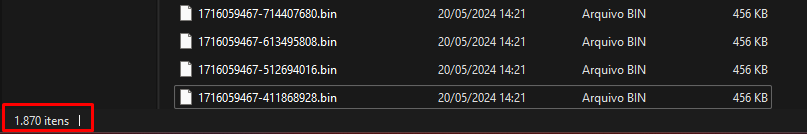

In [ ]:
frame_path = "../sample_data//1870.bin"
with open(frame_path, 'rb') as f:
    frame = np.fromfile(f, dtype=np.float32).reshape(-1, 4)

frame.shape

In [ ]:
depth = spherical_projection(point_cloud=frame, proj_fov_up=15.0, proj_fov_down=-15.0, proj_W=1024, proj_H=16)

In [ ]:
from PIL import Image

min_value = 0.
max_value = 100.

# normalizando para pixels
depth_normalized = depth.clip(min_value, max_value)
depth_normalized = (255.*(depth_normalized - min_value)/(max_value - min_value)).astype(np.uint8)

image = Image.fromarray(depth_normalized)
image.show()

In [ ]:
min_value = 0
max_value = 100

depth_original = depth_normalized / 255.0 * (max_value - min_value) + min_value
point_cloud = imageto_point_cloud(image=depth_original)
point_cloud.shape

In [ ]:
show_point_cloud(point_cloud)

In [ ]:
show_point_cloud(point_cloud, frame[:,0:3], compare=True)